Here we'll be looking at a training set of housing data and housing prices to try to make accurate predictions on the prices of houses in a separate test set.

Each house has been painstakingly documented so that we have 79 variables for each house, some of which are continuous (Square feet on first floor) and some of which are categorical (what neighborhood the house is in).

Here our goal is simply to explore the data.  Understanding what variables are likely to impact house prices, and which ones aren't, will help with developing an effective model.  Understanding our input variables makes it easier to understand when the model is going wrong or going right.  Entirely eliminating some variables (dimensionality reduction) may also increase the speed at which our model computes expected housing prices while also limiting overfitting.

Let's begin by importing the necessary modules and loading our data:

In [1]:
#Standard imports for data analysis
import numpy as np
import pandas as pd  
import matplotlib as mpl
import matplotlib.pyplot as plt

#Useful for making pretty plots
import seaborn as sns

#Load data
TrainingSet = pd.read_csv('data/train.csv')
TestSet = pd.read_csv('data/test.csv')

If we want a quick look at our data, we can look at the top 5 entries:

In [2]:
TrainingSet.head()
#TestSet.head()
#TrainingSet.tail()
#TestSet.tail()
#Note: TrainingSet.tail() will show the last 5 entries

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


We need to know the shape of the training and test sets so that we know how many examples we're working with, and to double-check the number of variables we're working with.

In [3]:
print("Training set shape: " + str(TrainingSet.shape))
print("Test set shape:     " + str(TestSet.shape))

Training set shape: (1460, 81)
Test set shape:     (1459, 80)


So we have 79 variables.  The house ID has a column, but should have no effect on the price of the house (assuming the houses are listed in random order).  The test set has no pricing column (because that's what we're trying to predict!) so it naturally has 1 less column.

Now we may want to know which of the 79 variables are continuous numbers, and which are categorical.  We can find that out here:

In [4]:
#Print the variables that are continuous (numbers)
print(TrainingSet.select_dtypes(include=[np.number]).columns)
#Print the variables that are categorical (objects)
print(TrainingSet.select_dtypes(include=[np.object]).columns)

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', '

So we see that 38 values are listed as 'numbers'.  However, 'ID' and 'SalePrice' are not truly variables, so we have 36 continuous variables.
We see 43 values are listed as 'objects'.  These 43 with the 36 continuous variables give us our 79 total variables.

If we want to quickly see which columns are missing variables (or how many missing values are present in general), we can use the missingno package:

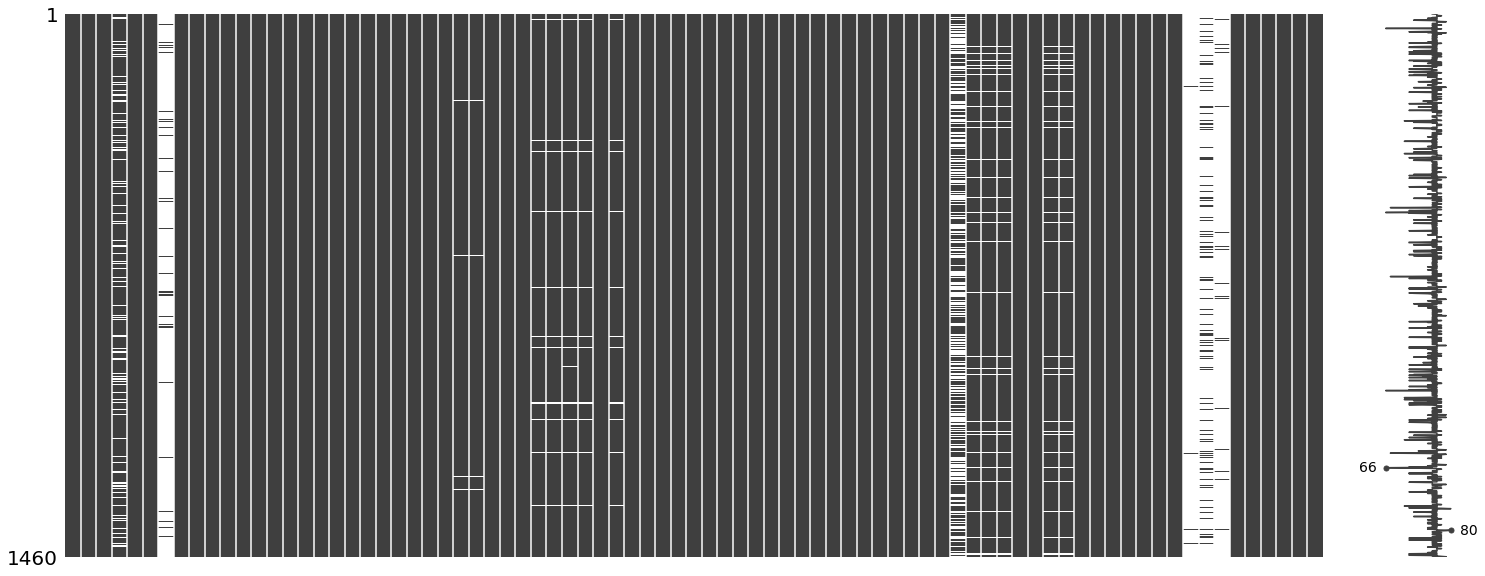

In [5]:
import missingno as msno

msno.matrix(TrainingSet)

Excluding the ID column of our data set, the 6th column is 'Alley'.  We see it's largely white.  This indicates it's mostly empty.  I guess most of our houses don't have access to an alley!  The large batch of 3 empty columns towards the right corresponds to the columns 'PoolQC' (pool quality), 'Fence', and 'MiscFeature'.  Evidently most of these houses also don't have pools or fences.

Let's take a quick look at what our house prices look like.

1.8828757597682129

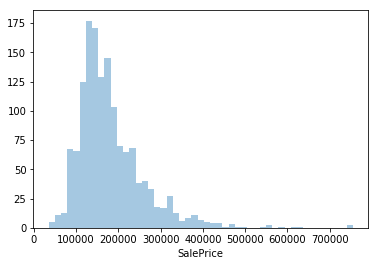

In [6]:
#Defining the X and Y we'll use in machine learning
Y = TrainingSet['SalePrice']
X = TrainingSet.iloc[:,1:80] #Exclude ID # and Sale Price
#X.head()

#Quick plot of what our house prices look like
sns.distplot(Y, kde=False)
Y.skew()

We see that our housing prices peak around ~$150k, and we have a skew value of 1.88.  Positive skew indicates that our distribution tails off at higher values.  We'd expect this in housing prices (a few houses are very large and thus have high prices far above the housing peak price).

Which features seem to be closely correlated to the sale price?  Let's look at our continuous features (numerical features).

In [7]:
TrainingSetNumerics = TrainingSet.select_dtypes(include=[np.number])
NumericCorrelations = TrainingSetNumerics.corr()
print(NumericCorrelations['SalePrice'].sort_values(ascending = False),'\n')

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

As expected, we see SalePrice has a correlation of 1 (exact match!).  Other highly correlated variables are 'OverallQual' (overall quality of the house, rated between 1 and 10, with 10 being the best) and 'GrLivArea' (the size of the living area in the house above ground in square feet).  These are both expected.  Anti-correlated variables are 'KitchenAbvGr' (kitchens above grade), 'EnclosedPorch' (enclosed porch area in square feet), and MSSubClass (a value based on the type of dwelling, with different types of housing given different numbers).  Some of the anticorrelated features make less sense (why does having a big enclosed porch hurt home value?), however these values are far more weakly anticorrelated than the other values are correlated.

Some values have almost no correlation, such as 'MoSold' (the month in which the house was sold).  In this case, we'd expect the time the house went onto the market to have little impact on the quality, and thus price, of the house.

We can view the correlations between all the numeric values in more detail:

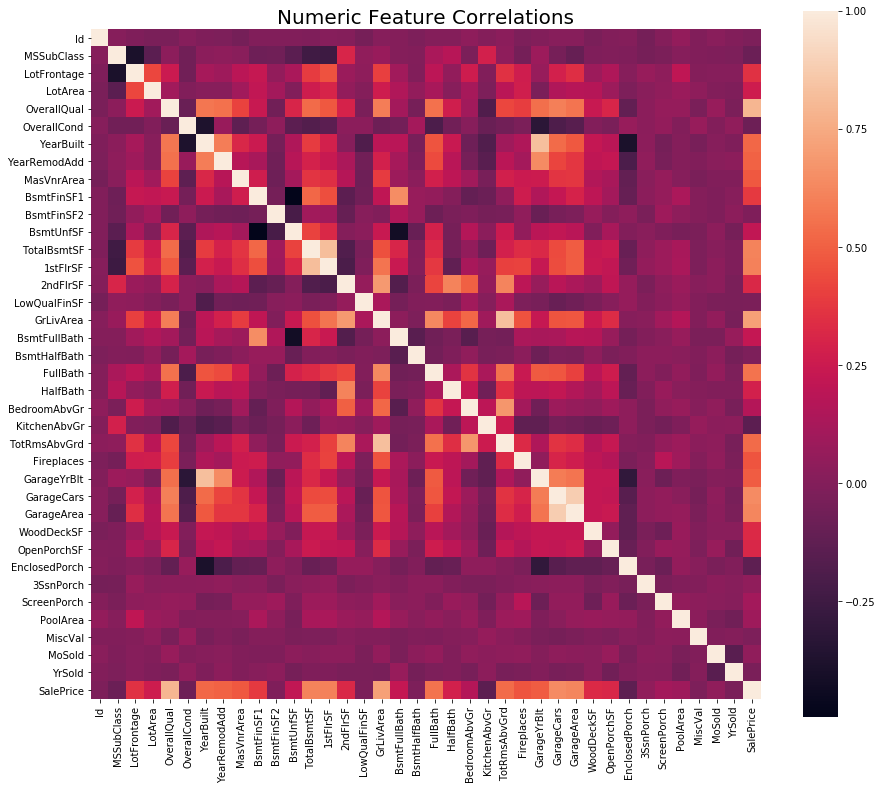

In [8]:
f , ax = plt.subplots(figsize = (15,13))
plt.title('Numeric Feature Correlations', y=1, size=20)
sns.heatmap(NumericCorrelations, square = True,  vmax=1) #max is set to 0.8, since highest correlation value is 0.79

As we can see, some features are highly correlated, such as 'YearBuilt' and 'GarageYrBuilt' (people tend to have garages built at the same time as the rest of the house!).  This may allow us to reduce the dimensionality of the data set in the future.  Looking specifically at the last row ('SalePrice'), we can see which values are most correlated with the house's ultimate price.  We see what was demonstrated above: 'OverallQual' is highly correlated with the sale price, but 'EnclosedPorch' is highly anti-correlated.

What about some of the non-numeric data?  Let's look at the housing price vs neighborhood:

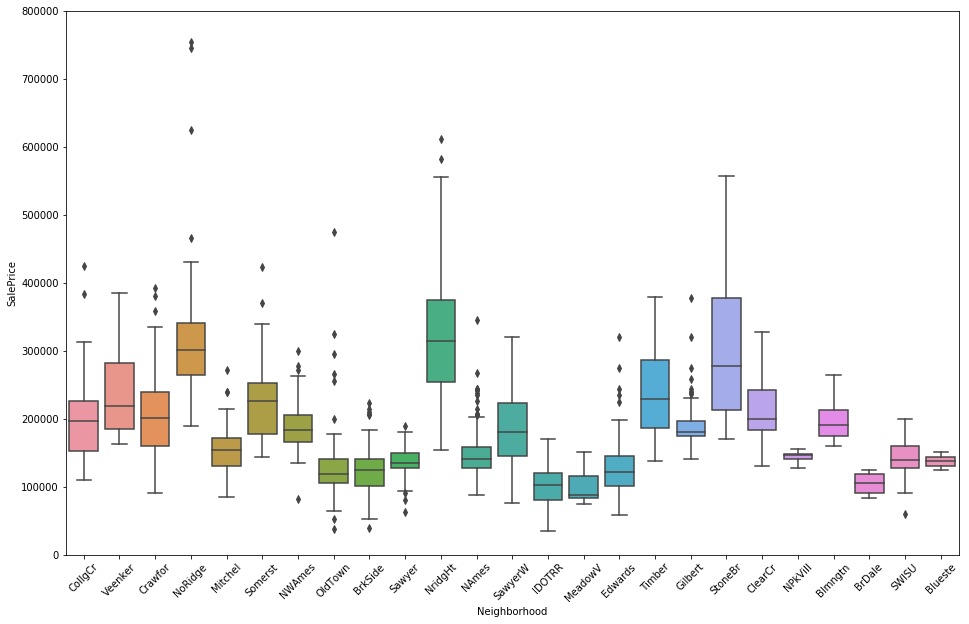

In [9]:
data = pd.concat([TrainingSet['SalePrice'], TrainingSet['Neighborhood']], axis=1)
f, ax = plt.subplots(figsize=(16, 10))
fig = sns.boxplot(x='Neighborhood', y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
xt = plt.xticks(rotation=45)

Some neighborhoods seem to lead to higher housing prices ('StoneBr' has a much higher average that 'BrDale').  This will be an important variable in determing other housing prices.

Let's look at all of the non-numeric data.  Which appear to be correlated with the house's price?

C:\Users\brend\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


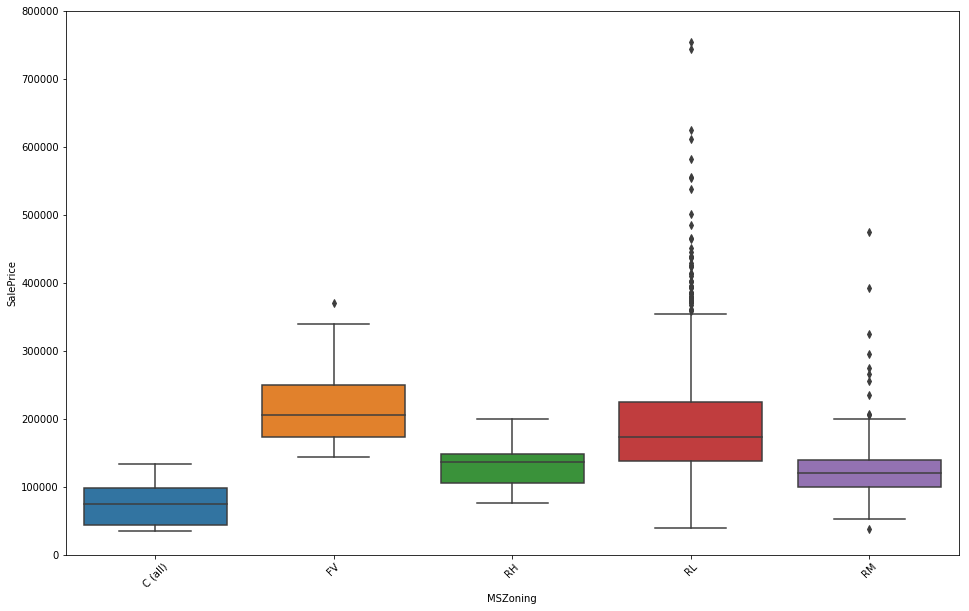

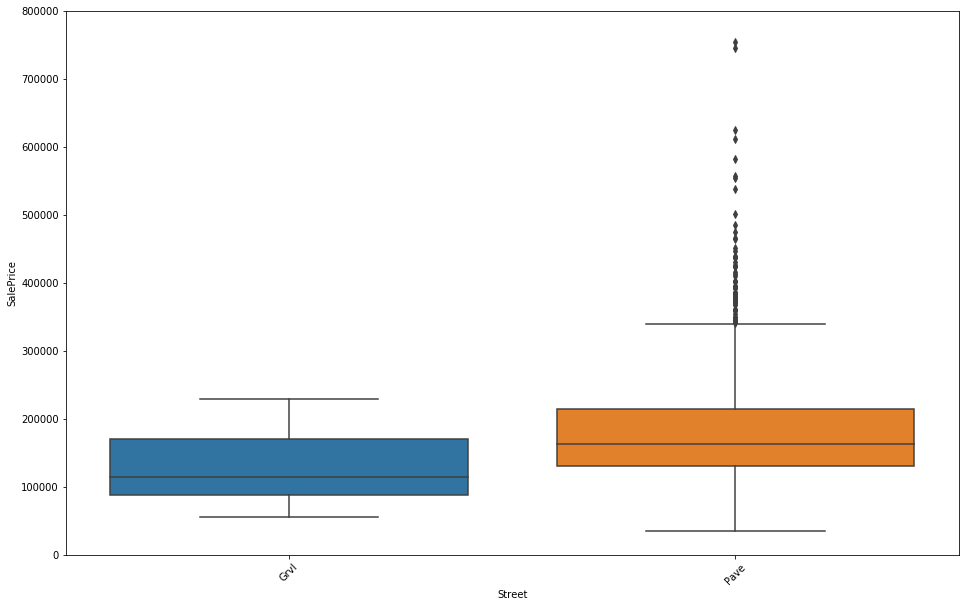

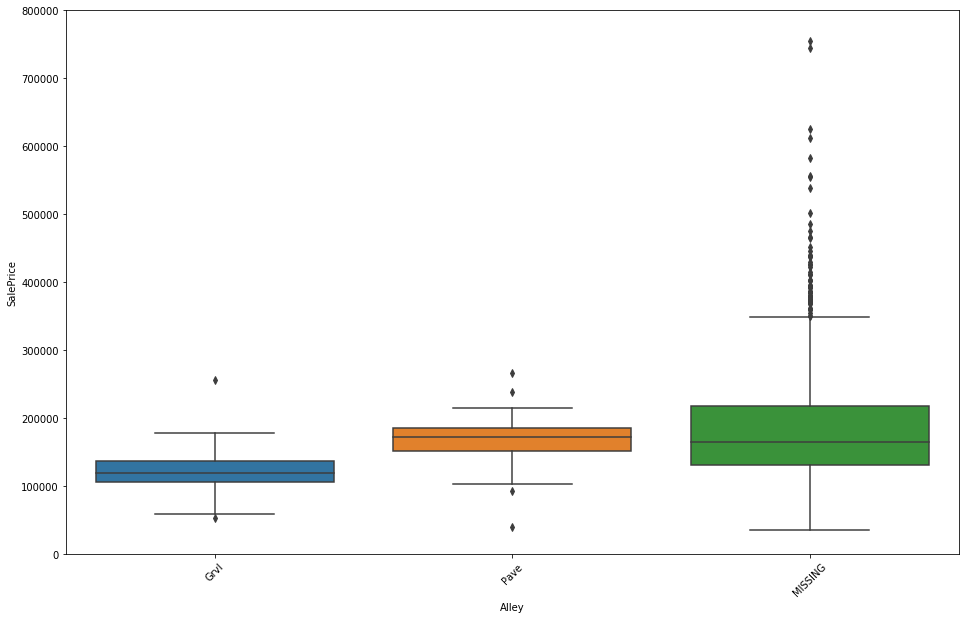

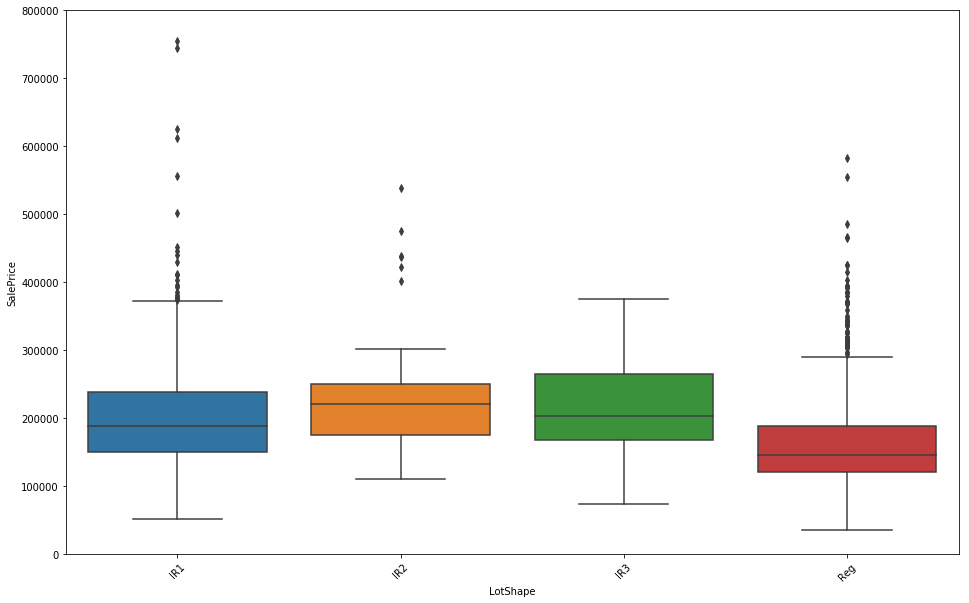

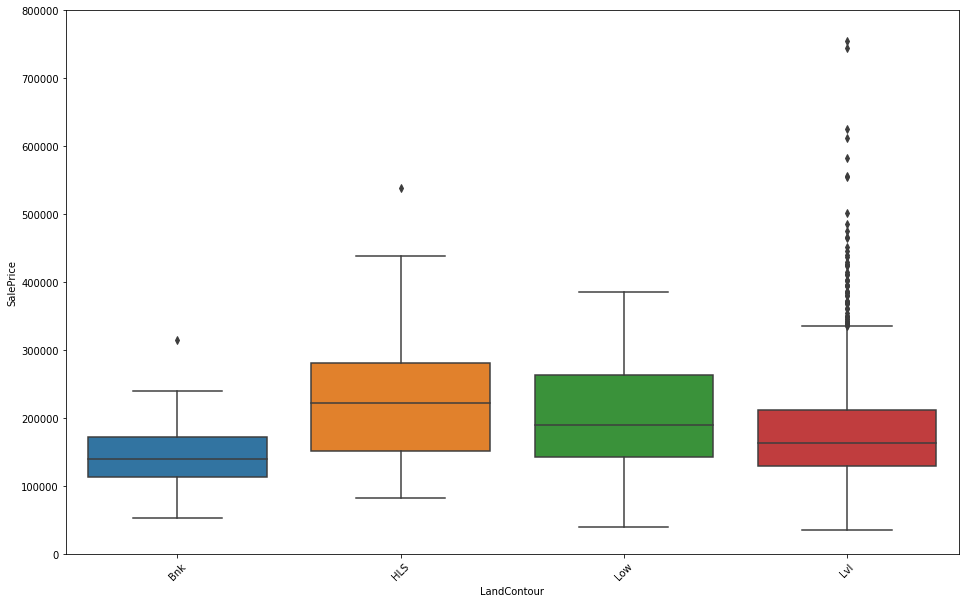

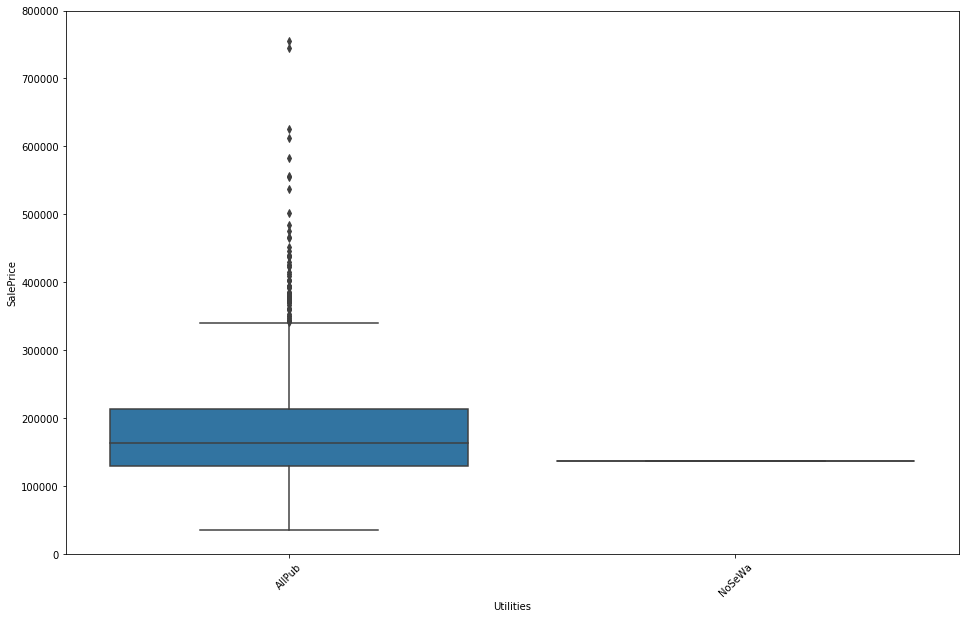

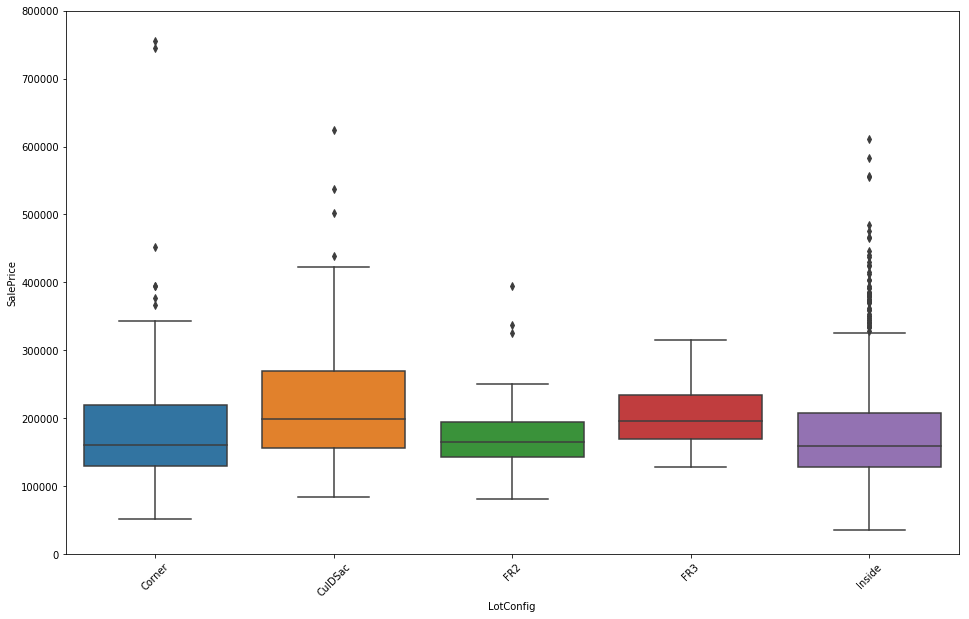

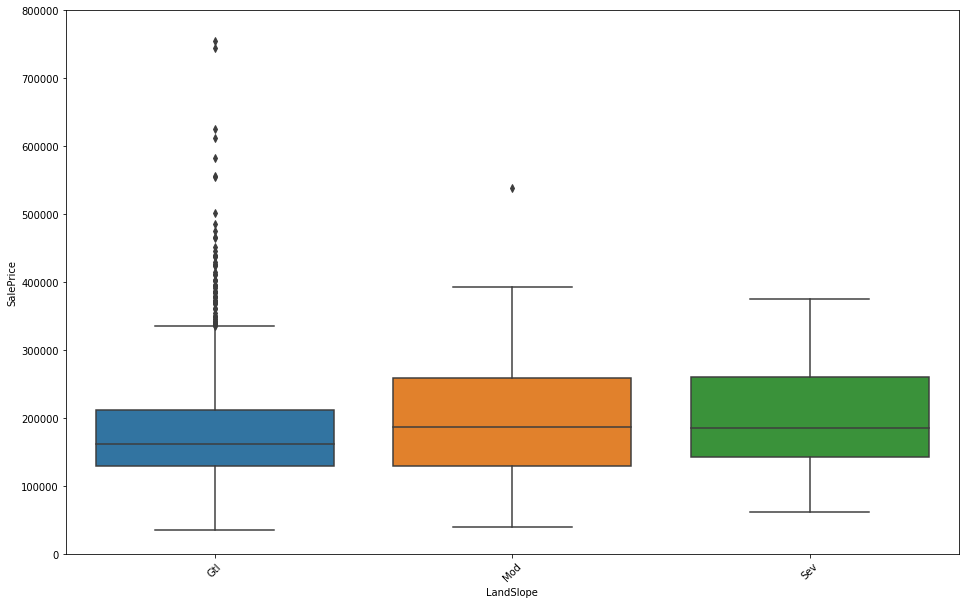

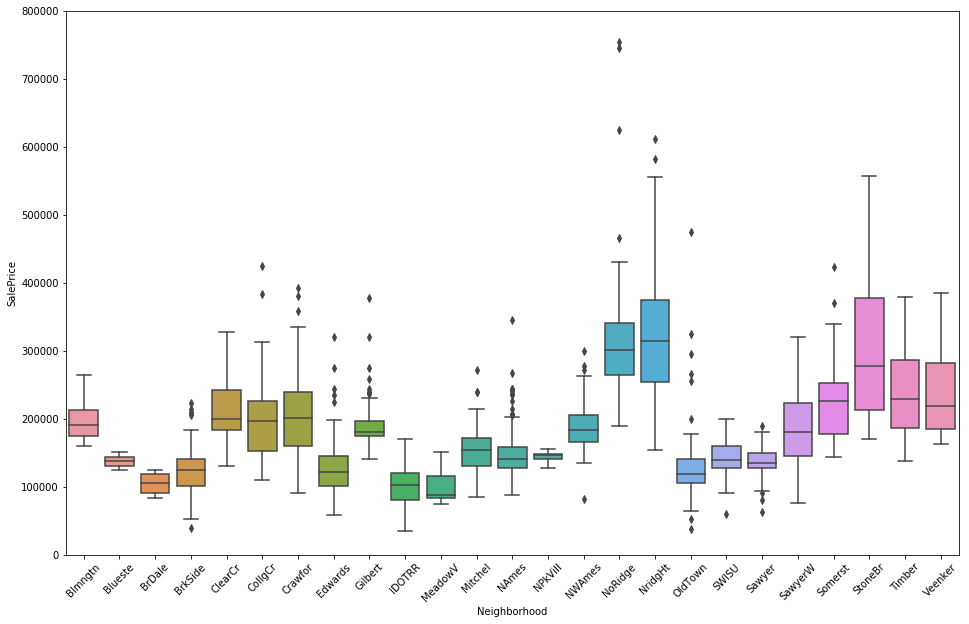

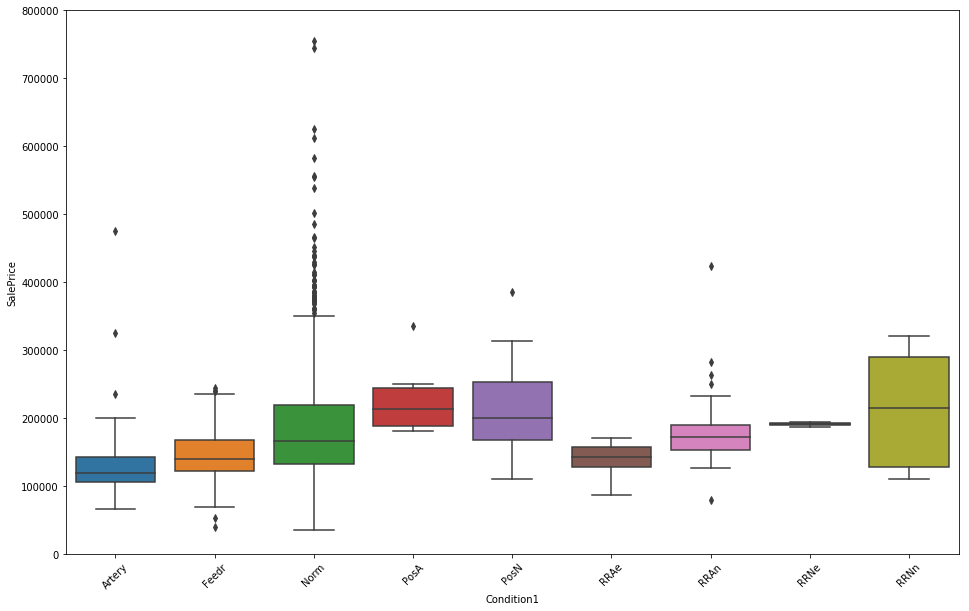

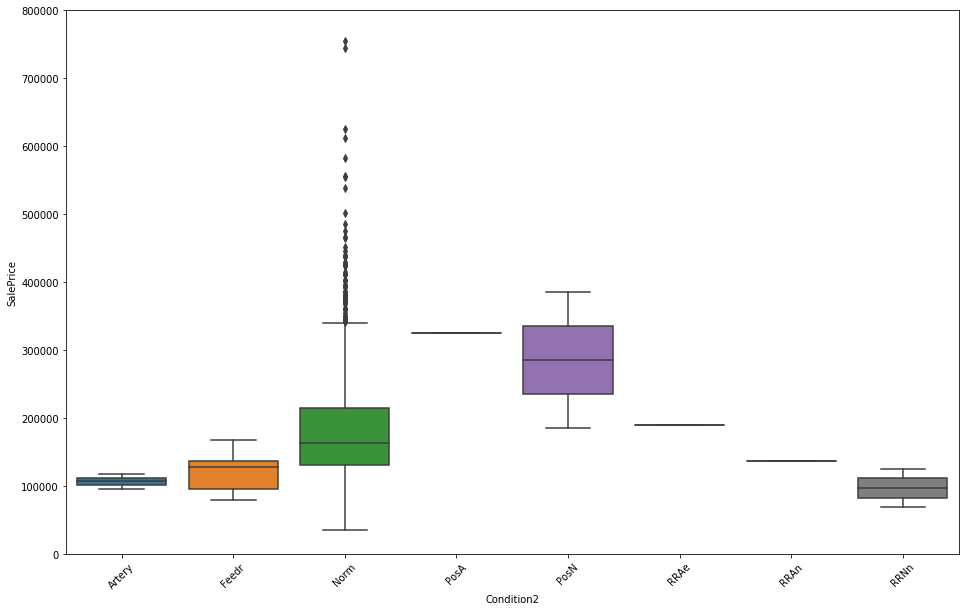

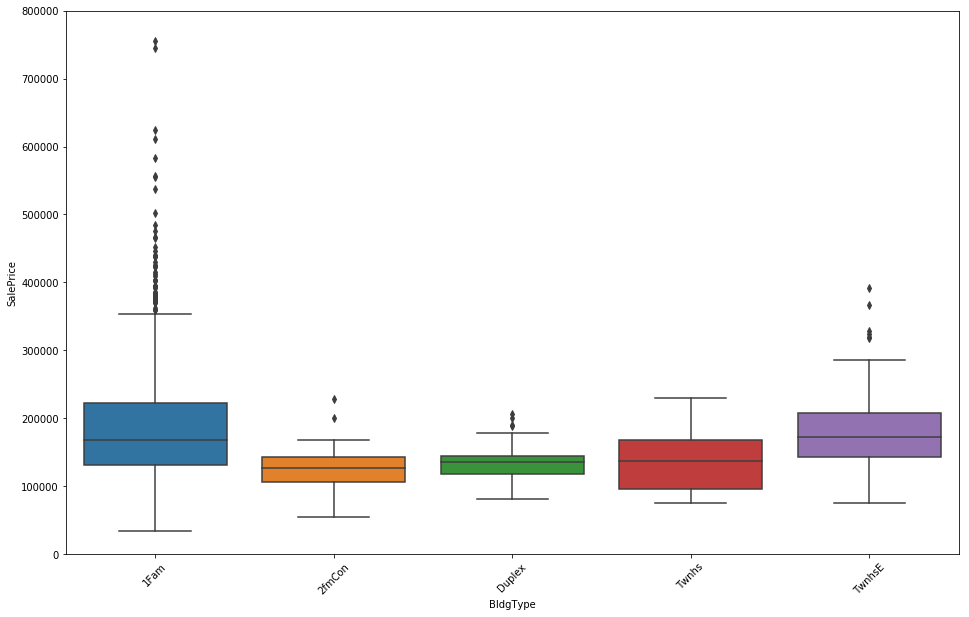

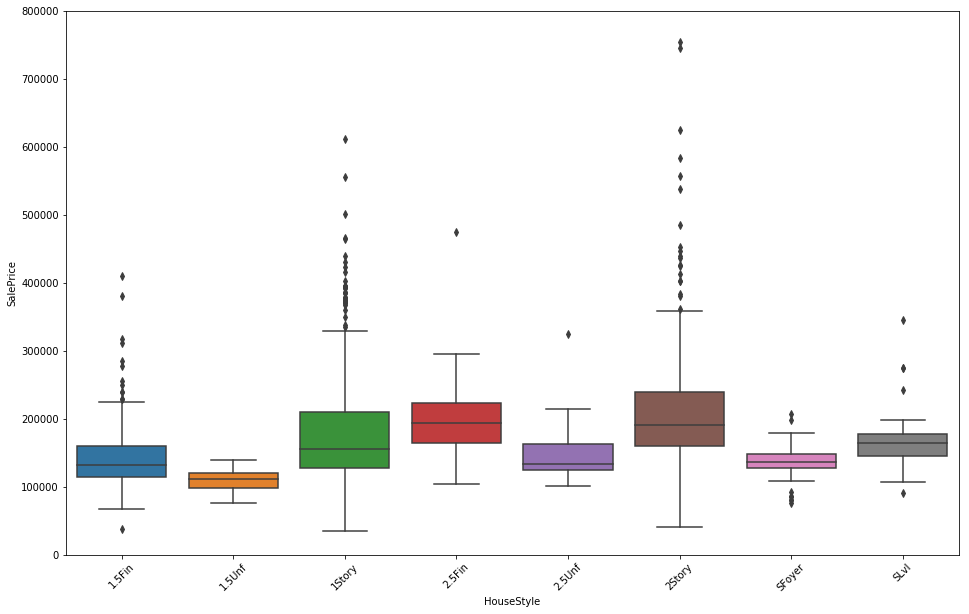

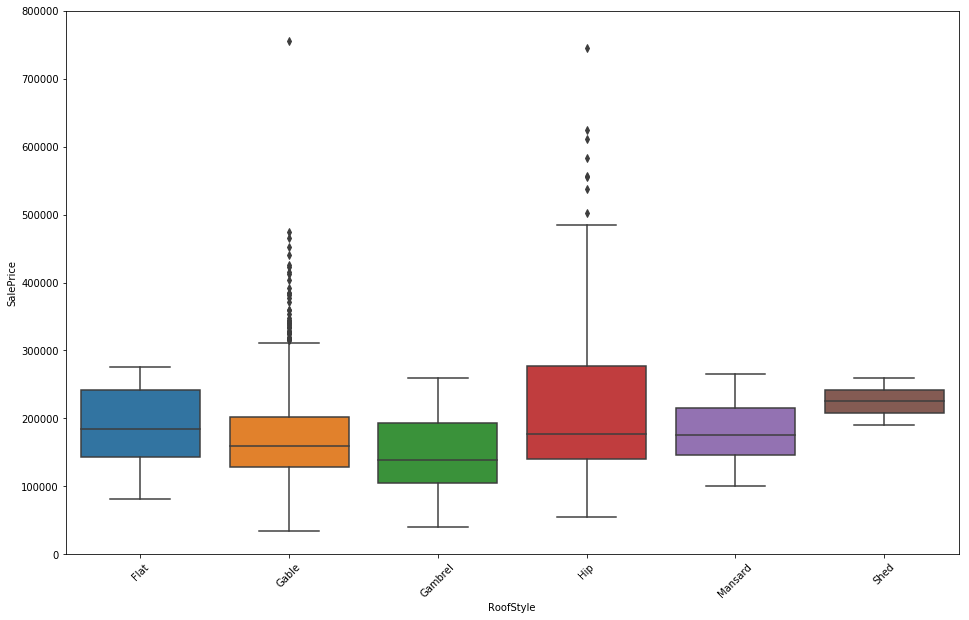

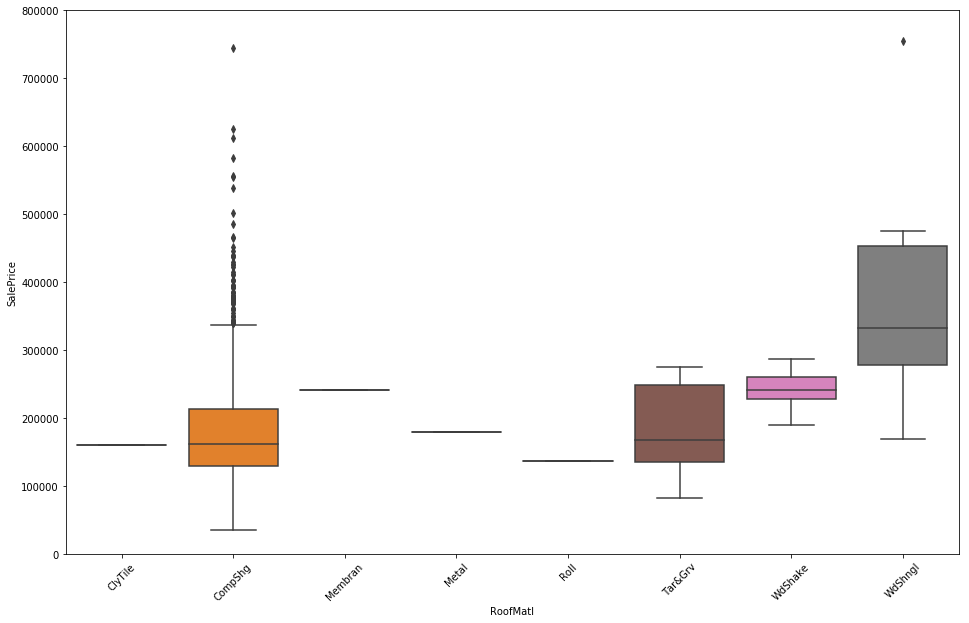

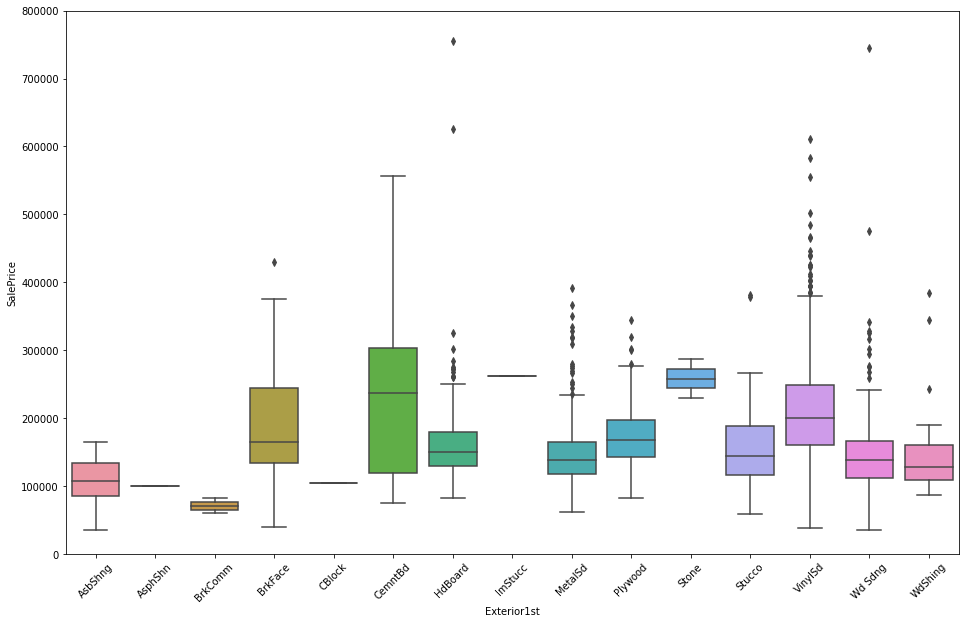

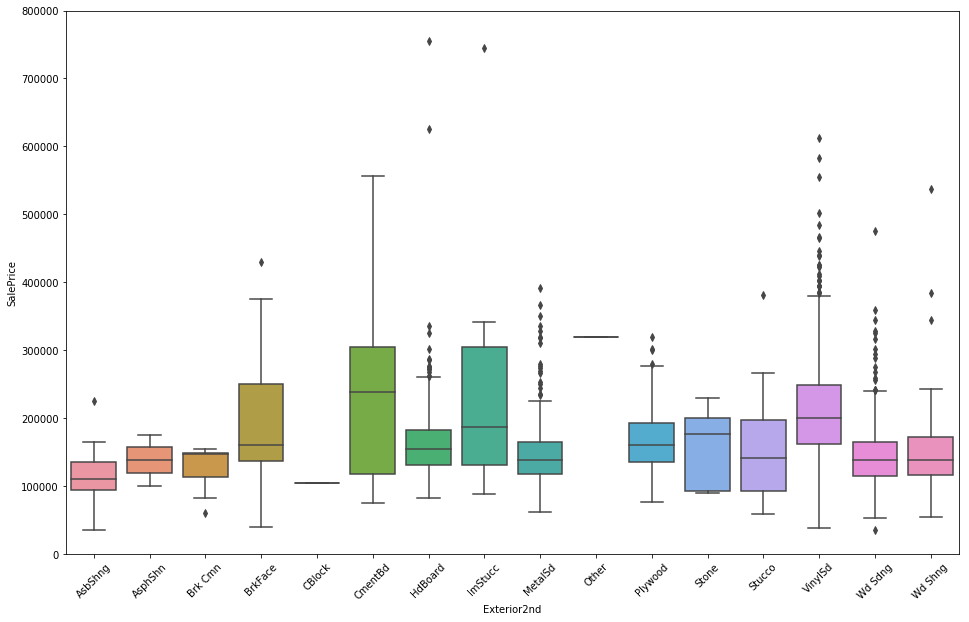

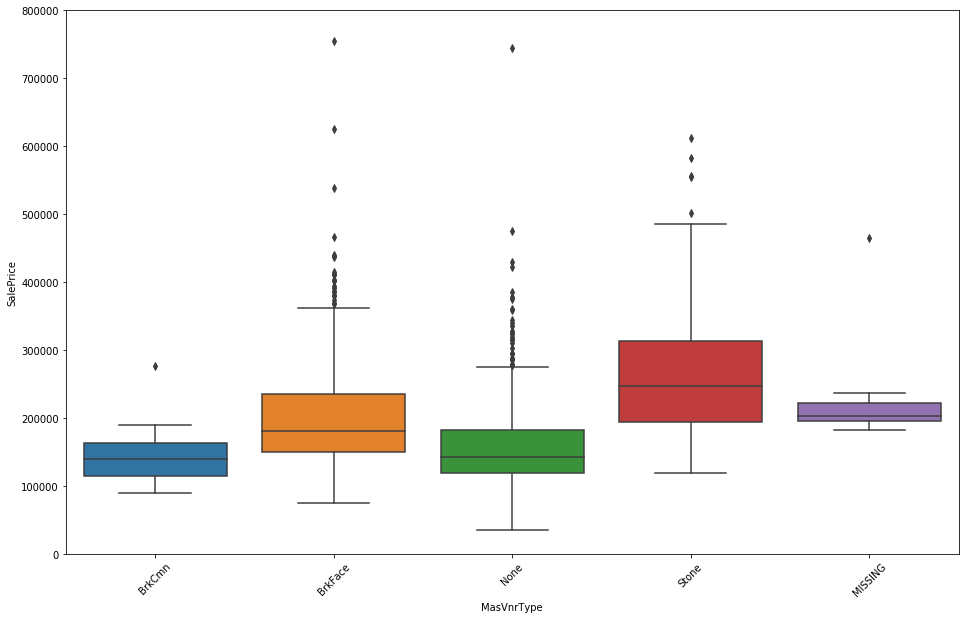

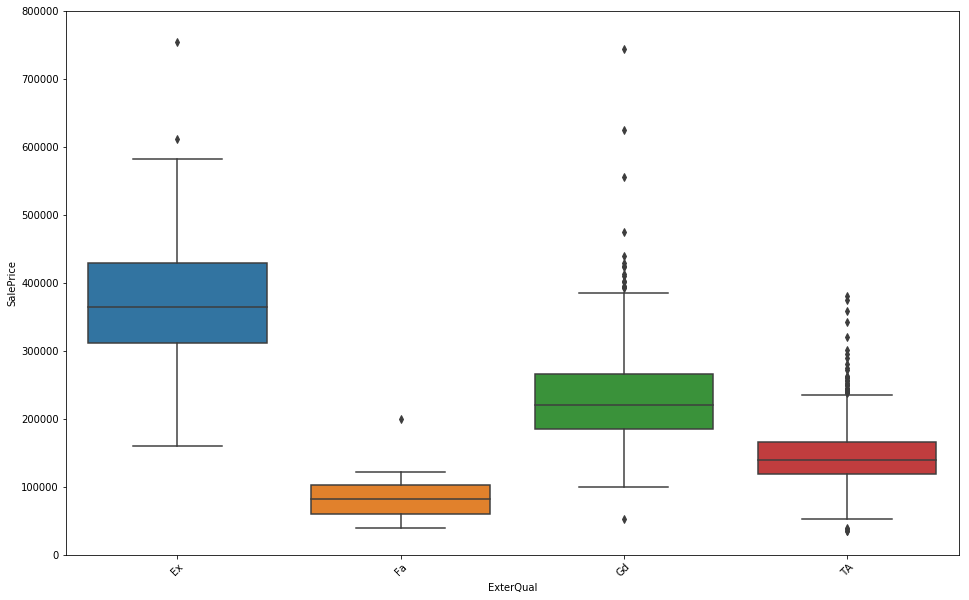

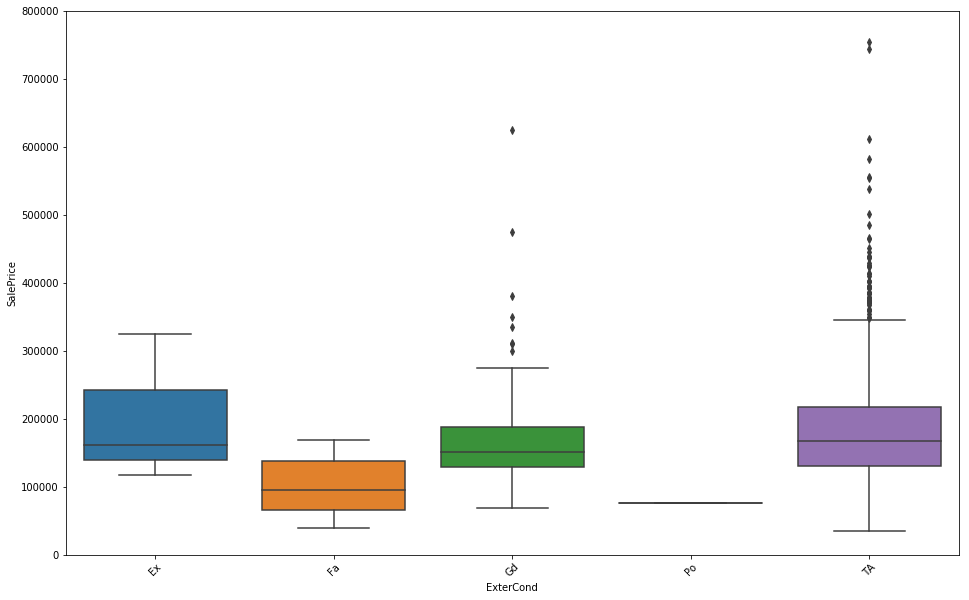

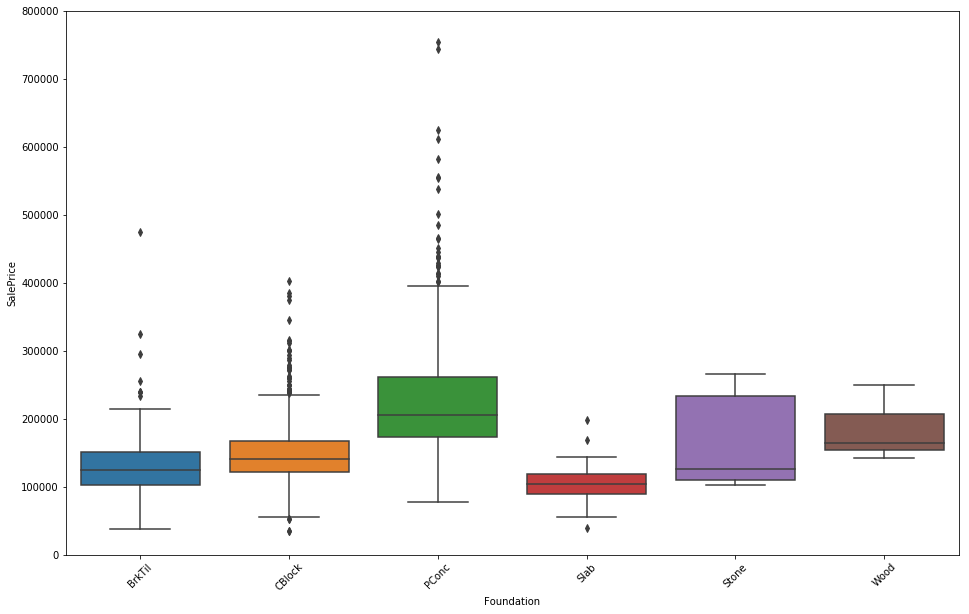

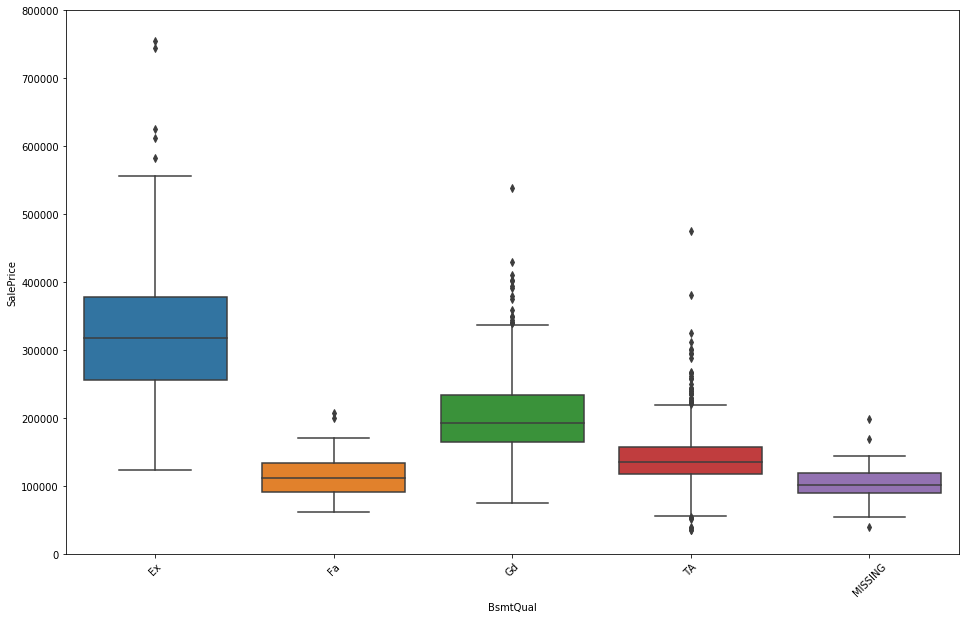

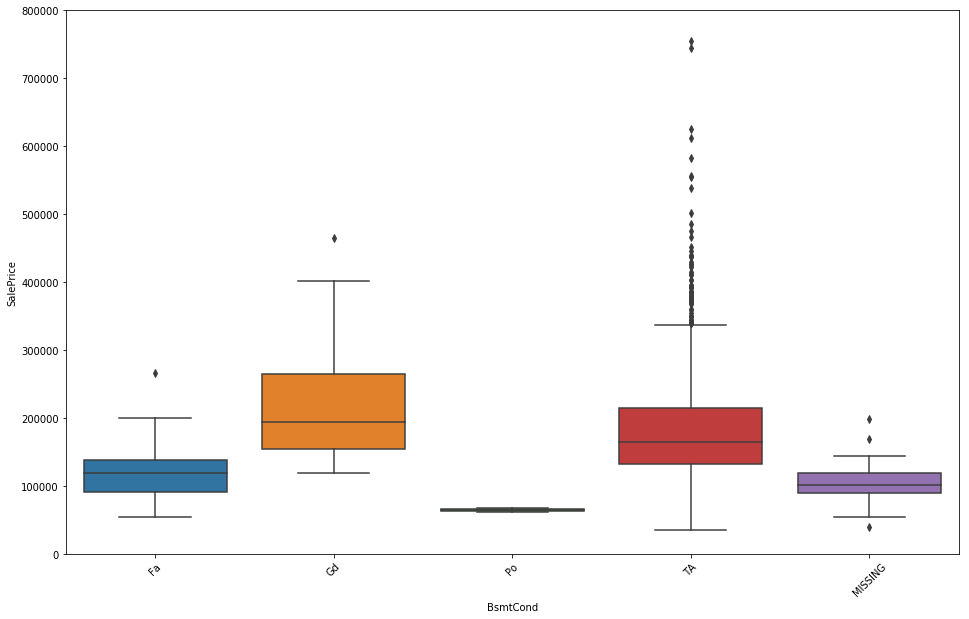

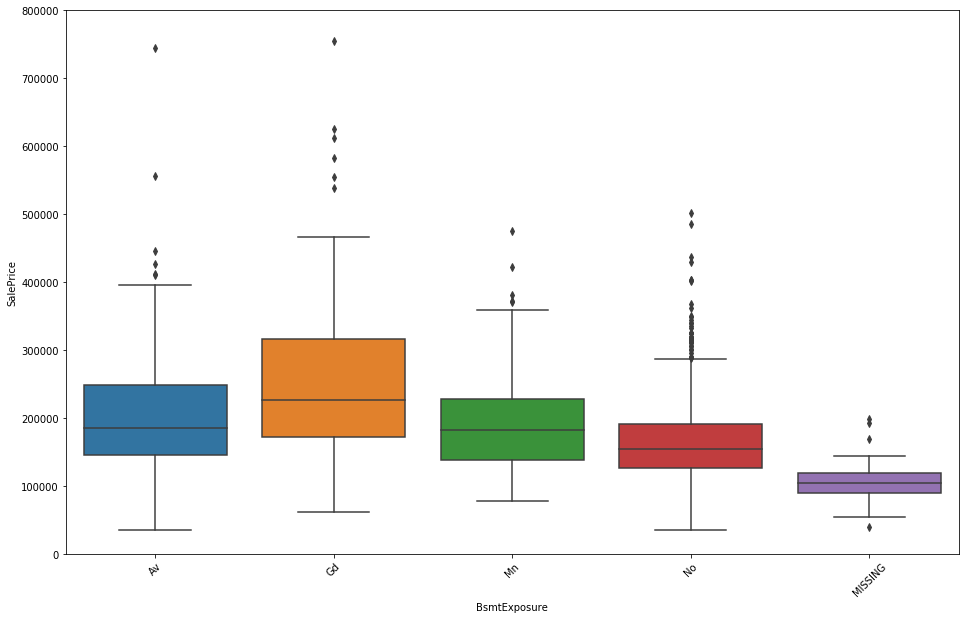

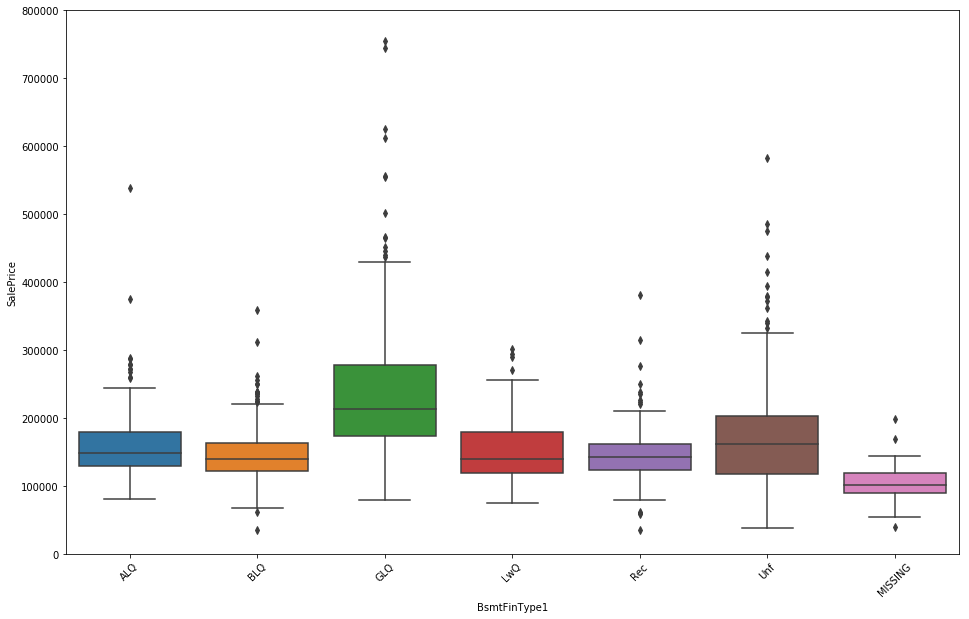

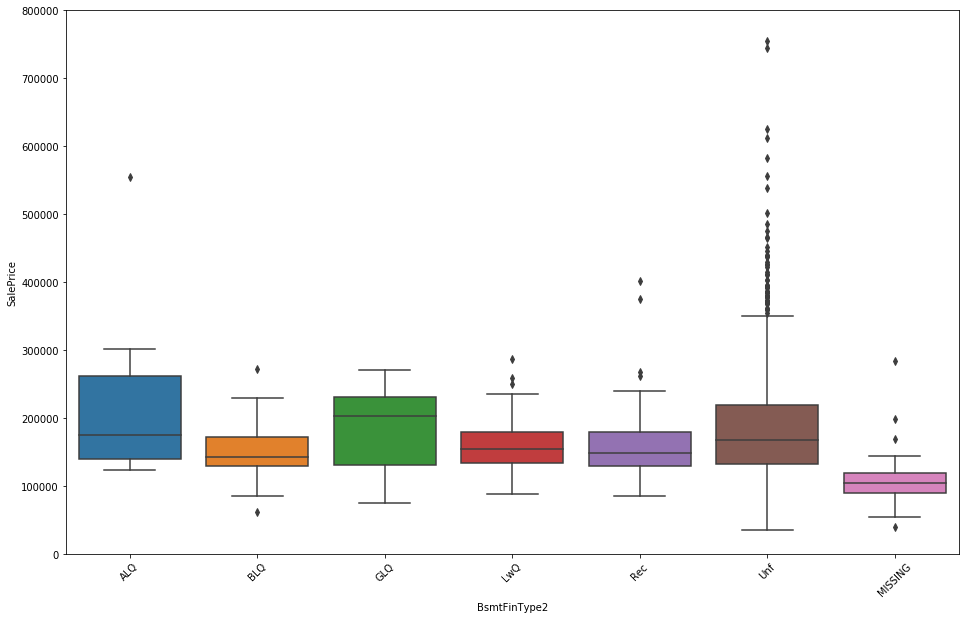

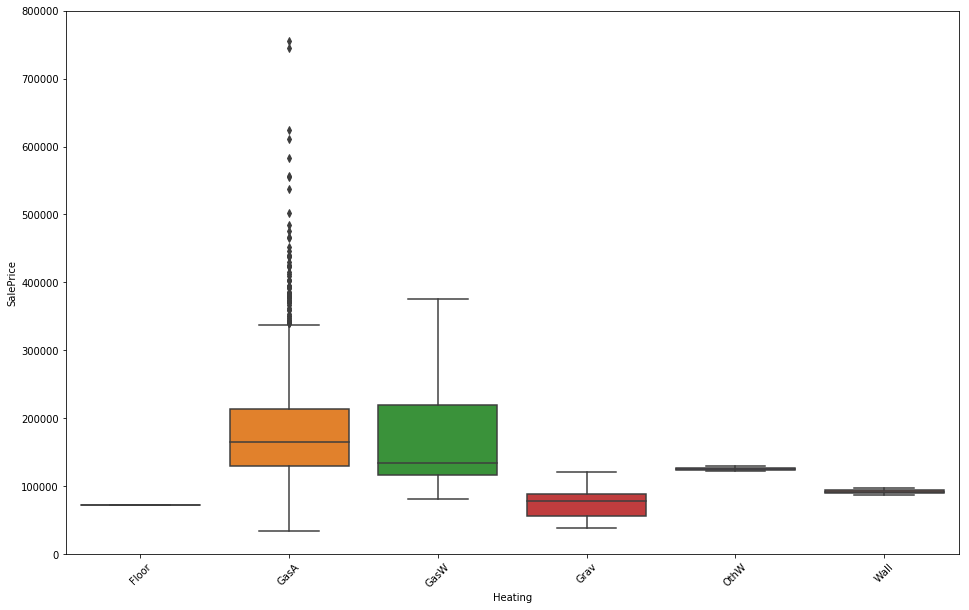

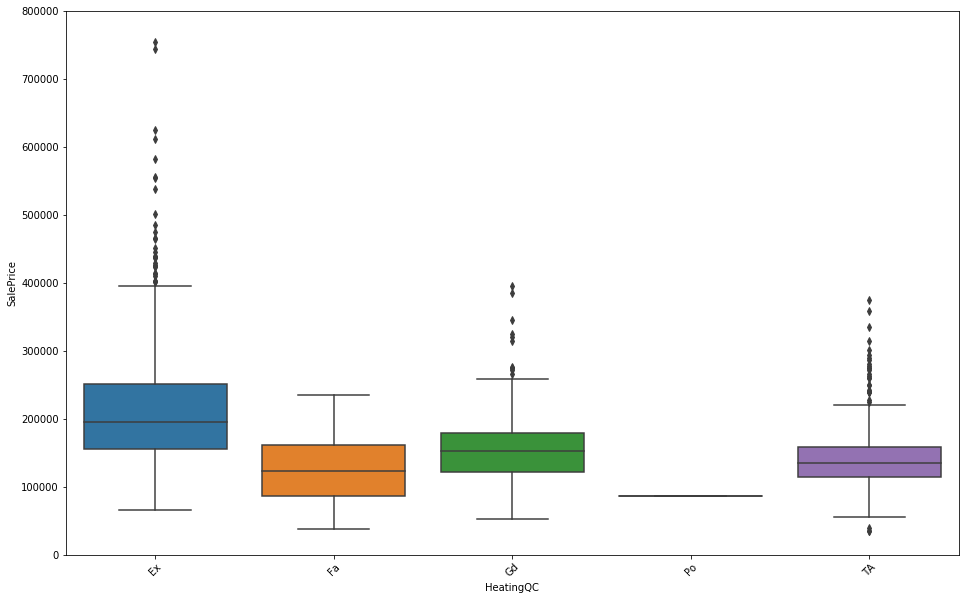

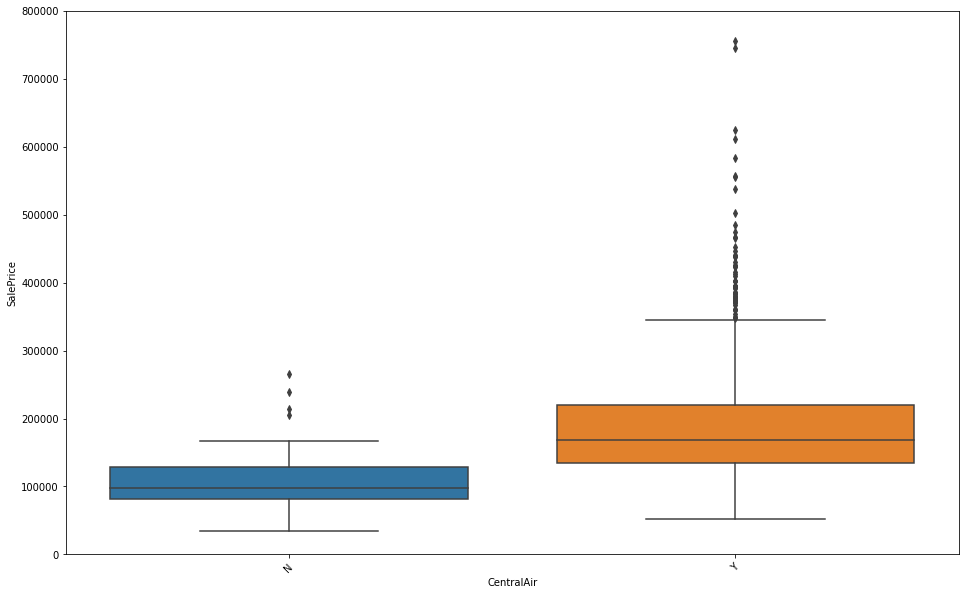

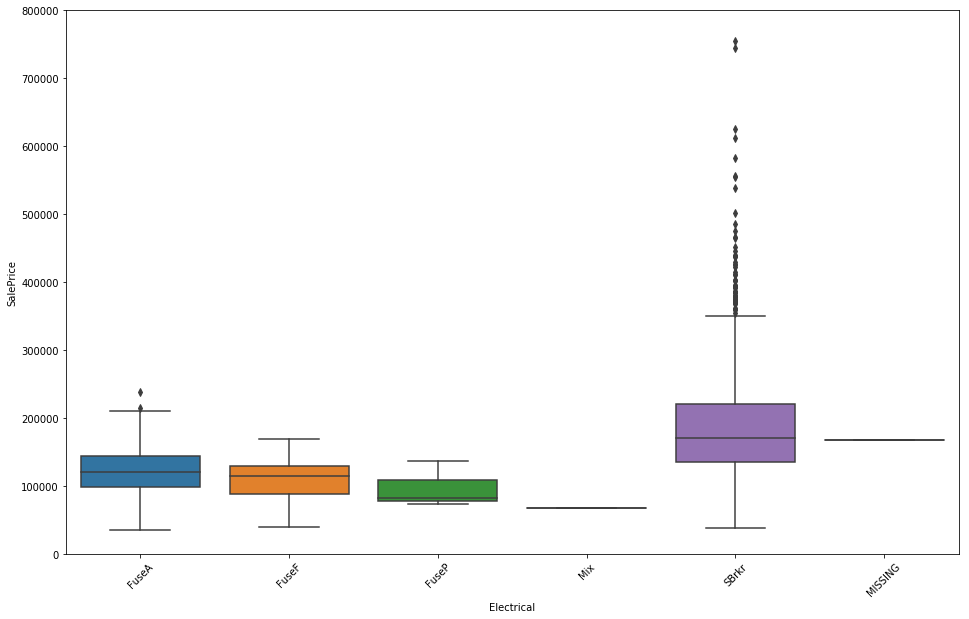

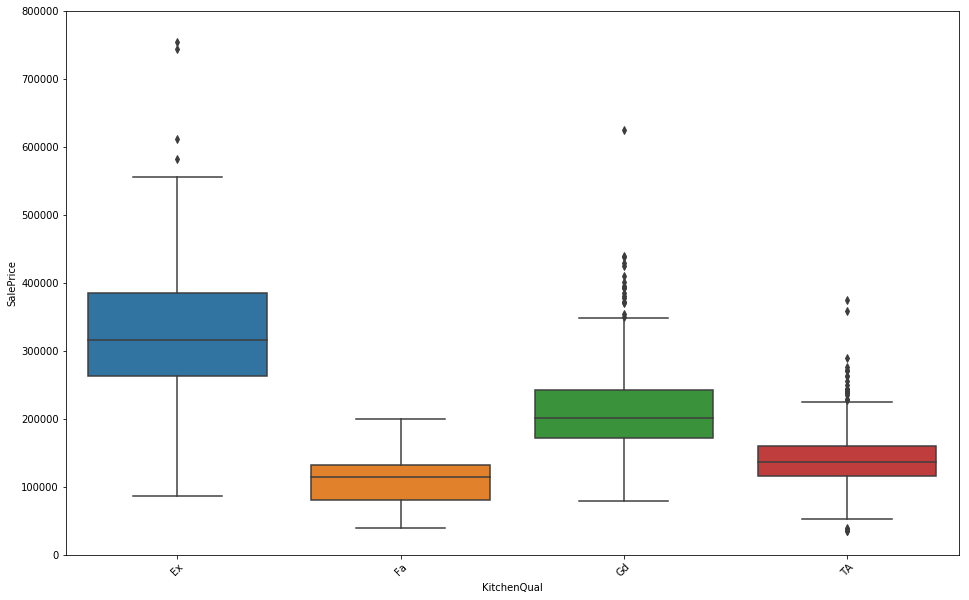

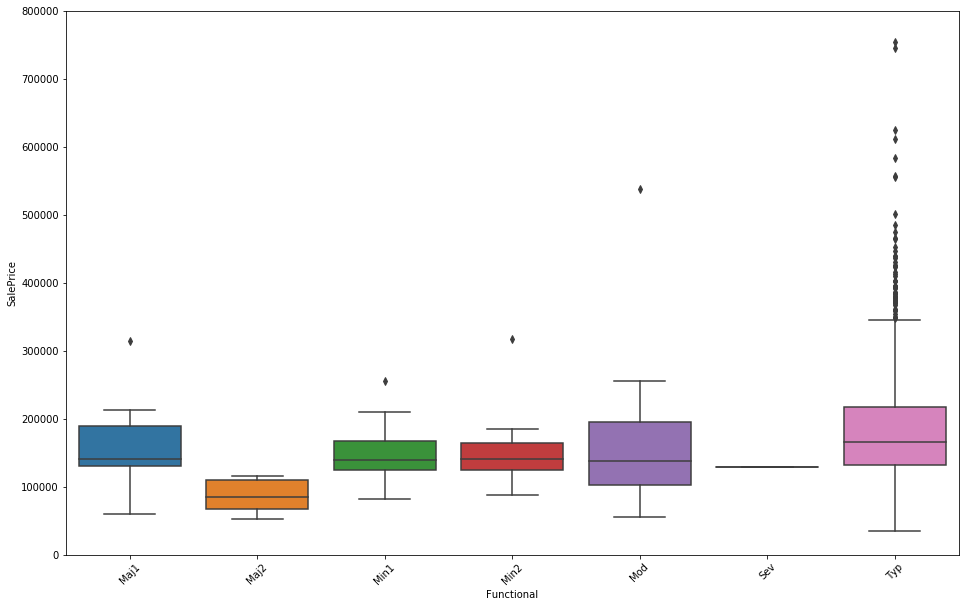

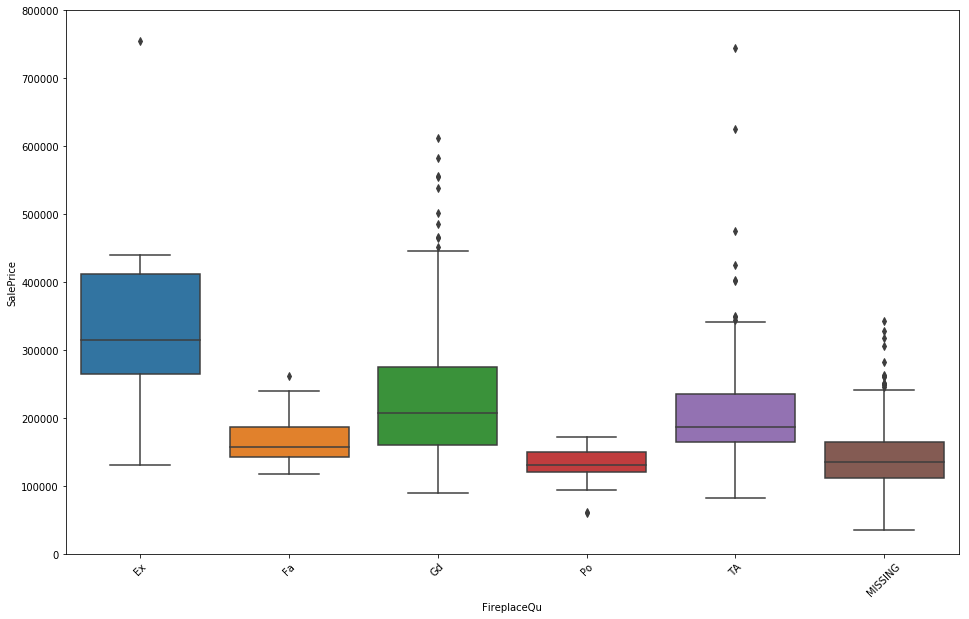

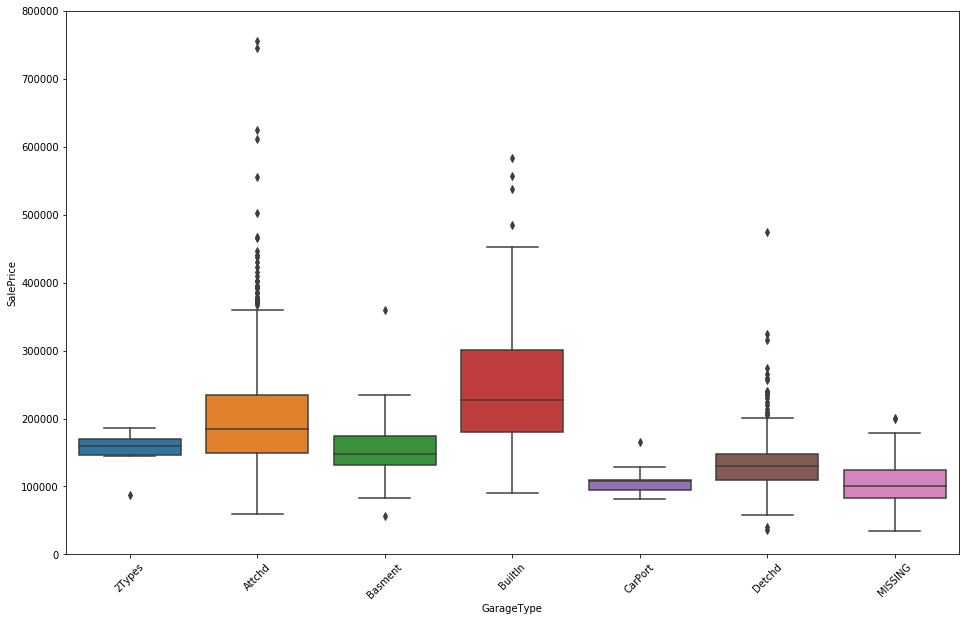

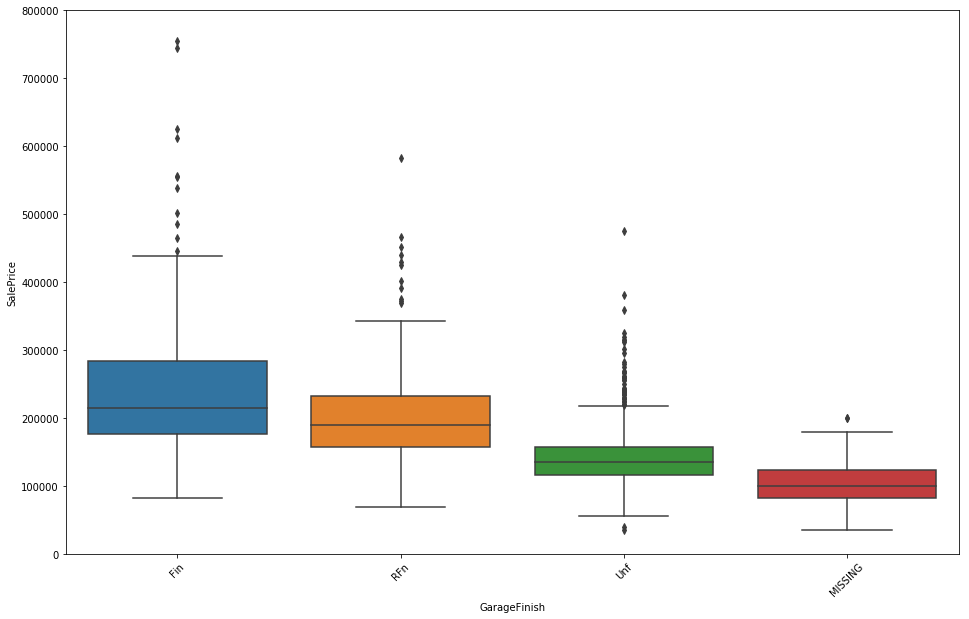

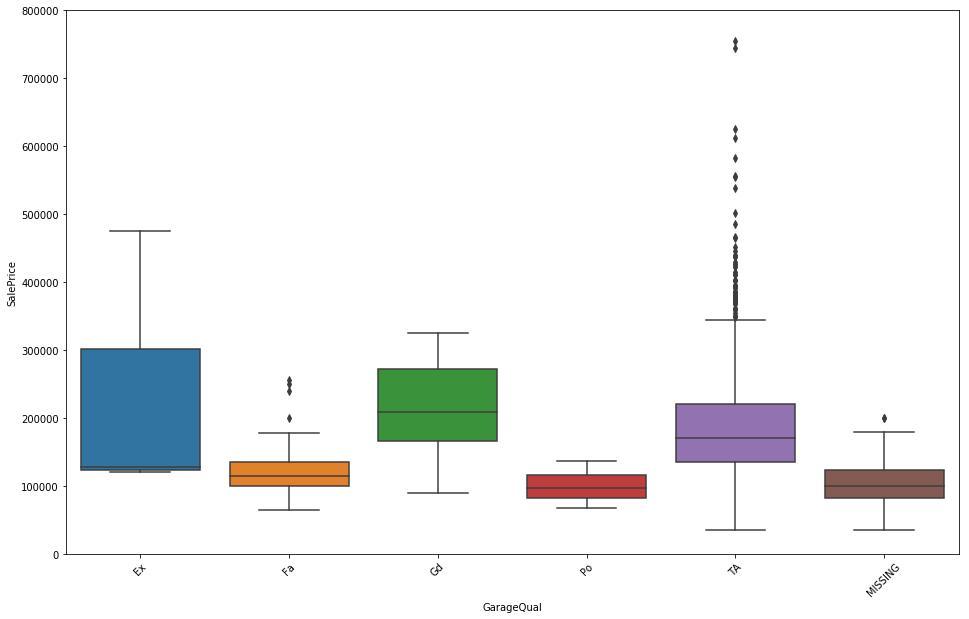

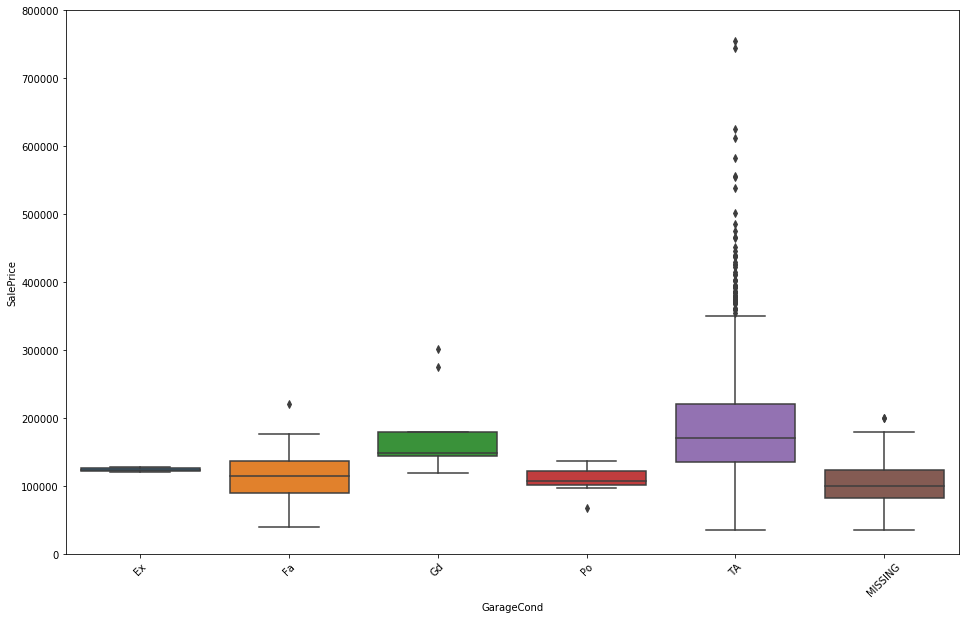

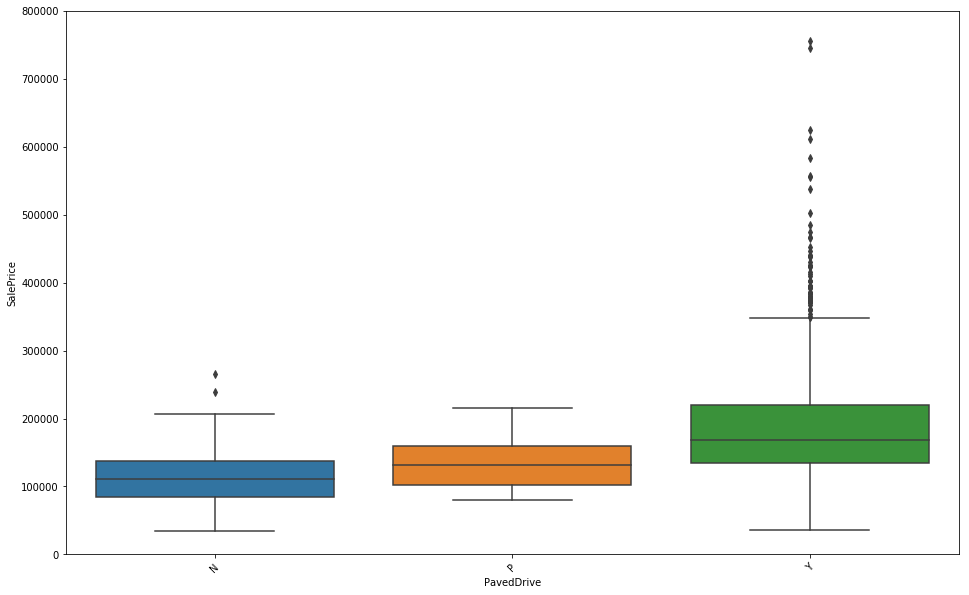

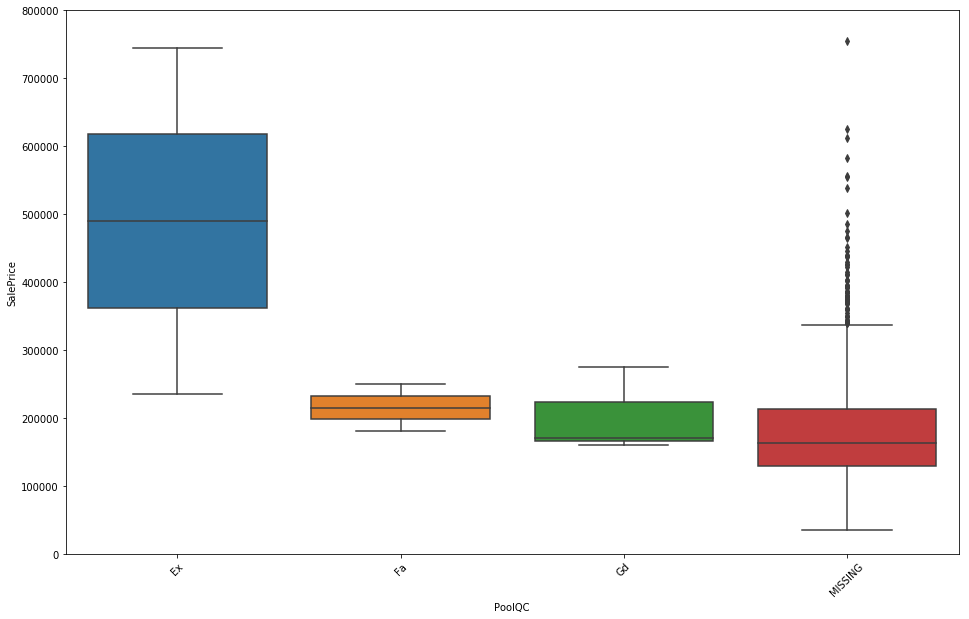

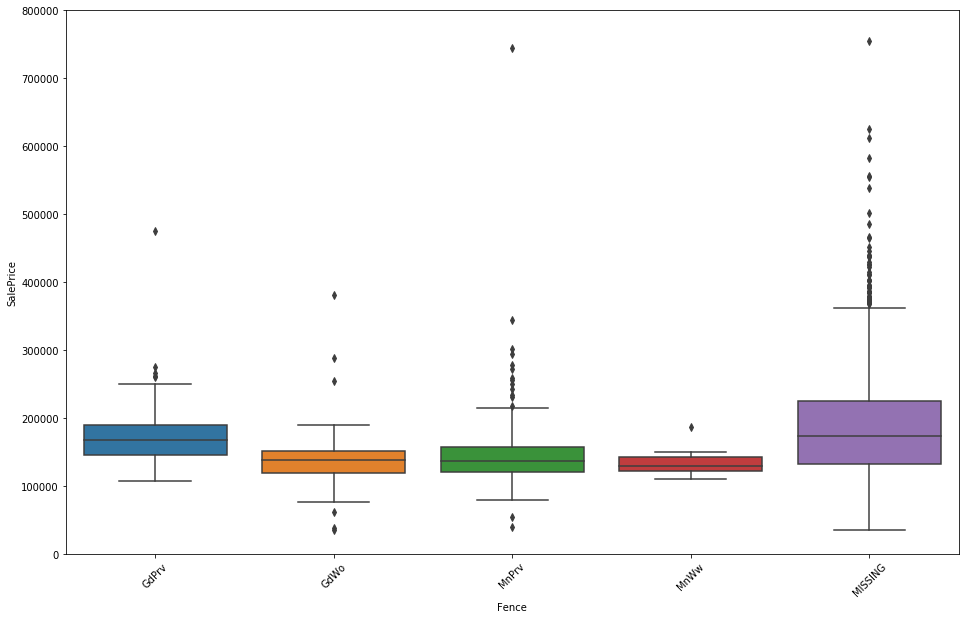

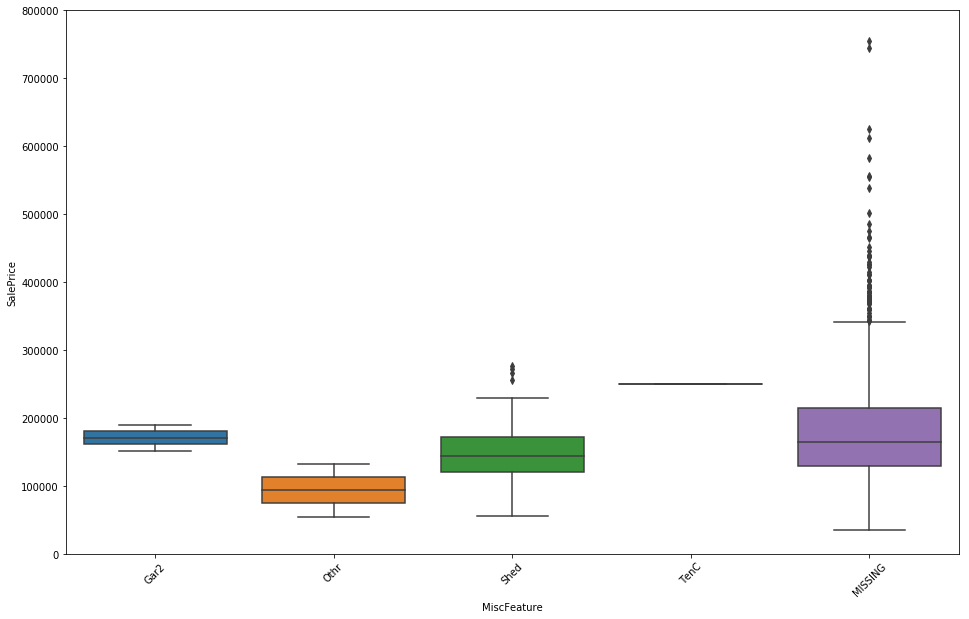

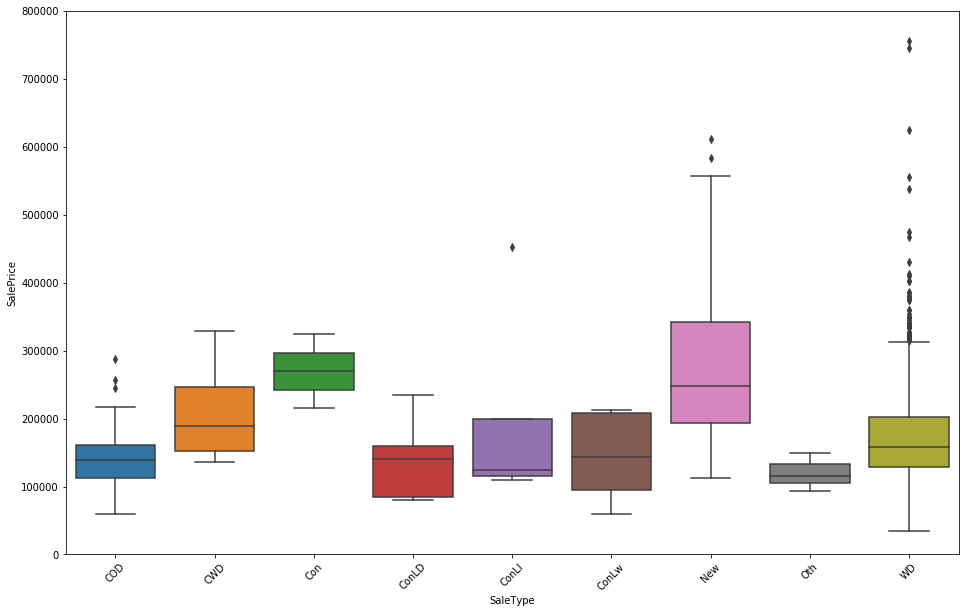

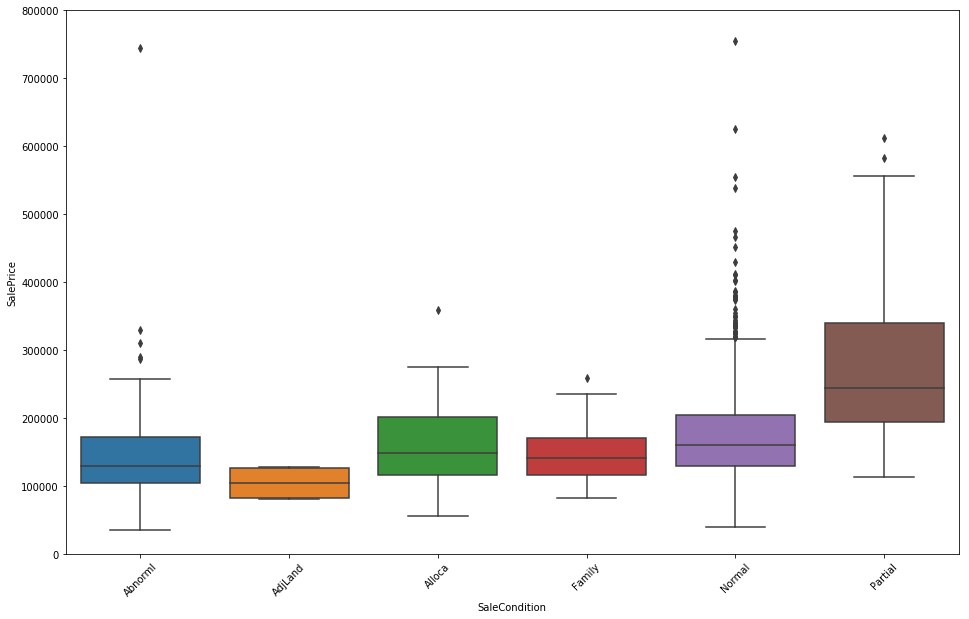

In [10]:
CategoryFeatures = TrainingSet.select_dtypes(include=[np.object])

#Create a new category 'MISSING' for data that's not available
for i in CategoryFeatures:
    TrainingSet[i] = TrainingSet[i].astype('category')
    if TrainingSet[i].isnull().any():
        TrainingSet[i] = TrainingSet[i].cat.add_categories(['MISSING'])
        TrainingSet[i] = TrainingSet[i].fillna('MISSING')      

#Plot all of the features vs. SalePrice
for i in CategoryFeatures:
    data = pd.concat([TrainingSet['SalePrice'], TrainingSet[i]], axis=1)
    f, ax = plt.subplots(figsize=(16, 10))
    fig = sns.boxplot(x=i, y="SalePrice", data=data)
    fig.axis(ymin=0, ymax=800000);
    xt = plt.xticks(rotation=45)


We can see that some of these variables are not valuable. 'Utilities' for example has every house belong to 1 value ('AllPub') except for a single house.  As a result we can't really use this variable to gain any insight into the house's price, and it should be excluded from our later analysis.

Other variables such as 'ExterQual' (a measure of the quality of the material on the exterior of the house) can have a large impact on the house's price and should be accounted for.

To summarize our results thus far, we should exclude the following numerical variables from our later analysis: 'PoolArea' (overlaps with other variables such as pool quality), 'MoSold' (shouldn't be strongly correlated with price), 'GarageArea' (overlaps with the better correlated variable 'GarageCars'), 'GarageYrBlt' (very well correlated with 'YearBuilt').  We can remove additional variables if necessary, but this should be a good start to reducing dimensionality to improve the algorithm.


And we should exclude the following categorical features: 'Utilities'.  Other variables also appear to have little impact on the house's price (such as the lot shape 'LotShape') and could be removed later if our algorithm appears to be performing poorly.